# SVM

### Content:
    Methods
    Class distribution
    Baseline model for comparison
    Feature selection
    Model tuning
    Final results
    Conclusions


## Methods

### This tab is about applying SVM to this research. So the first question is that what are Support Vector Machines? 

### Support Vector Machine (SVM) is a relatively simple Supervised Machine Learning Algorithm and it can be used for classification and regression. In general, it is more preferred for classification but is sometimes very useful for regression as well. 

### Basically, SVM is trying to find a hyper-plane that creates a boundary between the types of data. For example, in two-dimensional space, this hyper-plane is nothing but a line, and with more dimensions, the hyper-plane will be more complex. In SVM, we plot each data item in the dataset in an N-dimensional space, where N is the number of features in the data. Next, to separate the two classes of data points, there are many possible hyperplanes that could be chosen. Our objective is to find a plane that has the maximum margin, that is, the maximum distance between data points of both classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence. So generally speaking, SVM can only perform binary classification. 

### In this part, what we will focus is text data. So we want to find a hyper-plane to identify which word to be used in a tweet so that it can be retweeted. We will split these data into training set and testing set and plot each data item in the training set with 476 dimensional space. Then find the hyper-plane which has the maximum margin and use this classifier to explore the testing set to test the efficiency of this classifier.

#### Prepare Data for SVM (text data)

In [2]:
import pandas as pd
df = pd.read_csv("data/01-modified-data/textcleaning_py.csv")

#### Let's take a look of our labeled text data as it shows below.

In [5]:
df.head()

,id,retweet_count,retweeted,Clean_Text
0,1570097774930132992,1060,True,rt nickiminaj let hope ppl guy r dirty work lo...
1,1570097774355709954,0,False,ciaoszn charity work ☺ ️ ☺ ️ ☺ ️
2,1570097773839630337,53,True,rt marii_chaudhry congratulations team wepatri...
3,1570097773697015808,179,True,rt fact not wish work
4,1570097773672042498,161,True,rt jeonmanwon seungcheol suspicious like puppe...


#### Data preparation includes extracting dependent variable, retweeted, whether the tweet is retweeted or not and texts as input. And it also includes the process of spliting training and testing sets. We split the labeled text data into train and test with 70% trainning ratio.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["Clean_Text"], df["retweeted"], test_size=0.3, random_state=0)

#### First, we need to count vectorizer our texts as we do in Naive Bayes.

In [7]:
# count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
countvect = CountVectorizer()
Xtraincount = countvect.fit_transform(X_train)
Xtraincount.shape

(70, 476)

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer(use_idf=False).fit(Xtraincount)
Xtraintf = tf.transform(Xtraincount)
Xtraintf.shape

(70, 476)

In [9]:
tfidf = TfidfTransformer()
Xtraintfidf = tfidf.fit_transform(Xtraincount)
Xtraintfidf.shape

(70, 476)

## Class distribution

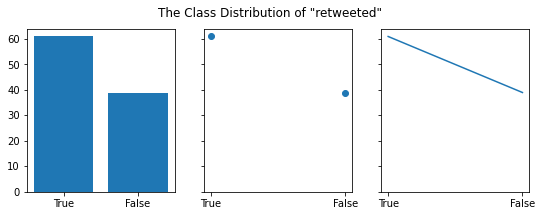

In [28]:
import matplotlib.pyplot as plt
data = df["retweeted"]
from collections import Counter
data = Counter(data)
names = list(data.keys())
values = list(data.values())
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(["True", "False"], values)
axs[1].scatter(["True", "False"], values)
axs[2].plot(["True", "False"], values)
fig.suptitle('The Class Distribution of "retweeted"')
plt.show()

In [29]:
print(data)

Counter({True: 61, False: 39})


#### The output Y has two class, "True" and "False", about 60% of the all dataset is "Ture" while 40% of the all dataset is "False". Such a proportion is beneficial to classification. If there are too many or too few proportion of categories, such as 90% or 10% of categories, the final accuracy will be poor. But under this dataset, this should not be the case.

## Baseline model for comparison

#### In this part we use a random classifier
#### For generate_label_data(), we choose the same proportion as above, that is, class_labels=[True,False] weights=[0.61,0.39]

In [34]:
import random
import numpy as np
def generate_label_data(class_labels, weights,N=10000):
    y=random.choices(class_labels, weights = weights, k = N)
    print("-----GENERATING DATA-----")
    print("unique entries:",Counter(y).keys())
    print("count of labels:",Counter(y).values()) # counts the elements frequency
    print("probability of labels:",np.fromiter(Counter(y).values(), dtype=float)/len(y)) # counts the elements' frequency
    return y
#TEST
y=generate_label_data([True,False],[0.61,0.39],10000)

-----GENERATING DATA-----
unique entries: dict_keys([False, True])
count of labels: dict_values([3848, 6152])
probability of labels: [0.3848 0.6152]


In [38]:
## RANDOM CLASSIFIER
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
def random_classifier(y_data):
    ypred=[]
    max_label=np.max(y_data); #print(max_label)
    for i in range(0,len(y_data)):
        ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))
    print("-----RANDOM CLASSIFIER-----")
    print("count of prediction:",Counter(ypred).values()) # counts the elements' frequency
    print("probability of prediction:",np.fromiter(Counter(ypred).values(),dtype=float)/len(y_data)) # counts the elements' frequency
    print("accuracy",accuracy_score(y_data, ypred))
    print("percision, recall, fscore,",precision_recall_fscore_support(y_data,ypred))
print("\nBINARY CLASS: UNIFORM LOAD")
y=generate_label_data([True,False],[0.61,0.39],10000)
random_classifier(y)


BINARY CLASS: UNIFORM LOAD
-----GENERATING DATA-----
unique entries: dict_keys([False, True])
count of labels: dict_values([3840, 6160])
probability of labels: [0.384 0.616]
-----RANDOM CLASSIFIER-----
count of prediction: dict_values([5016, 4984])
probability of prediction: [0.5016 0.4984]
accuracy 0.4946
percision, recall, fscore, (array([0.37821027, 0.61024721]), array([0.49088542, 0.49691558]), array([0.42724388, 0.54778096]), array([3840, 6160]))


## Feature selection

#### In this part, I choose to do feature selection using SelectFromModel
#### As we know, linear models penalized with the L1-norm have sparse solutions, that is, many of estimated coefficients are zero to reduce the dimensionality of the data. In particular, sparse estimators useful for this purpose are the Lasso for regression, and of logisticRegression and LinearSVC for classification, and in this part, we choose to use LinearSVC as we want to apply SVM to our dataset. And we use the function, cross_val_score to get the best feature combination.

In [116]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
print(Xtraintfidf.shape)
lsvc = LinearSVC(C=10000, penalty="l1", dual=False).fit(Xtraintfidf, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(Xtraintfidf)
Xtestcount = countvect.transform(X_test)
Xtesttfidf = tfidf.transform(Xtestcount)
X_t = model.transform(Xtesttfidf)
print(X_new.shape)
print(X_t.shape)
print("We can know that, we select",X_new.shape[1],"of 476 features in this process.")

(70, 476)
(70, 97)
(30, 97)
We can know that, we select 97 of 476 features in this process.


## Model tuning

### In this part, we compare the SVMs with Linear kernels, Polynomial kernels, with RBF kernels and with Sigmoid kernels.

#### the SVMs with Linear kernels

In [145]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
clf_score_tr = []
clf_score_te = []
for i in np.arange(0.1, 2.5, 0.1):
    model = SVC(C=i,kernel="linear")
    clf = model.fit(X_new, y_train)
    clf_score_tr.append(clf.score(X_new, y_train))
    clf_score_te.append(clf.score(X_t, y_test))

In [146]:
clf_score_tr

[0.6142857142857143,
 0.6142857142857143,
 0.6142857142857143,
 0.6142857142857143,
 0.6142857142857143,
 0.6428571428571429,
 0.6714285714285714,
 0.7714285714285715,
 0.8571428571428571,
 0.9142857142857143,
 0.9571428571428572,
 0.9714285714285714,
 0.9714285714285714,
 0.9714285714285714,
 0.9857142857142858,
 0.9857142857142858,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [147]:
clf_score_te

[0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.7,
 0.8,
 0.8,
 0.9,
 0.9,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9666666666666667,
 0.9666666666666667,
 0.9666666666666667,
 0.9666666666666667,
 0.9666666666666667,
 0.9333333333333333,
 0.9333333333333333]

#### From the above, we can find that when C = 1.8, SVM with Linear kernels perform the best with the lowest training error and the lowest testing error.

In [148]:
model = SVC(C=1.8,kernel="linear")
clf = model.fit(X_new, y_train)
predict_te = clf.predict(X_t)
predict_tr = clf.predict(X_new)
# Calculate the confusion matrix and classification report for the train and test data. 
# Train data
print("-----------train data-----------")
print(confusion_matrix(y_train, predict_tr))
print(classification_report(y_train, predict_tr))
# Test data
print("-----------test data-----------")
print(confusion_matrix(y_test, predict_te))
print(classification_report(y_test, predict_te))

-----------train data-----------
[[27  0]
 [ 0 43]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        27
        True       1.00      1.00      1.00        43

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

-----------test data-----------
[[12  0]
 [ 1 17]]
              precision    recall  f1-score   support

       False       0.92      1.00      0.96        12
        True       1.00      0.94      0.97        18

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [141]:
# Save the results in a data frame. 
report_tr = classification_report(y_train, predict_tr, output_dict=True)
report_tr = pd.DataFrame(report_tr).transpose()
report_te = classification_report(y_test, predict_te, output_dict=True)
report_te = pd.DataFrame(report_te).transpose()

In [142]:
# display the results data frame
print(report_tr)
print(report_te)

              precision  recall  f1-score  support
False               1.0     1.0       1.0     27.0
True                1.0     1.0       1.0     43.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     70.0
weighted avg        1.0     1.0       1.0     70.0
              precision    recall  f1-score    support
False          0.857143  1.000000  0.923077  12.000000
True           1.000000  0.888889  0.941176  18.000000
accuracy       0.933333  0.933333  0.933333   0.933333
macro avg      0.928571  0.944444  0.932127  30.000000
weighted avg   0.942857  0.933333  0.933937  30.000000


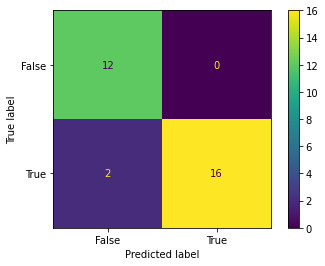

In [144]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predict_te, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

#### SVM with Polynomial kernels

In [153]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
clf_score_tr = []
clf_score_te = []
for i in np.arange(0.1, 3, 0.1):
    model = SVC(C=i,kernel="poly",degree = 2)
    clf = model.fit(X_new, y_train)
    clf_score_tr.append(clf.score(X_new, y_train))
    clf_score_te.append(clf.score(X_t, y_test))

In [154]:
clf_score_tr

[0.6285714285714286,
 0.6857142857142857,
 0.7285714285714285,
 0.7428571428571429,
 0.8,
 0.8428571428571429,
 0.8857142857142857,
 0.8857142857142857,
 0.9,
 0.9285714285714286,
 0.9285714285714286,
 0.9285714285714286,
 0.9285714285714286,
 0.9428571428571428,
 0.9571428571428572,
 0.9571428571428572,
 0.9714285714285714,
 0.9714285714285714,
 0.9714285714285714,
 0.9714285714285714,
 0.9714285714285714,
 0.9714285714285714,
 0.9857142857142858,
 0.9857142857142858,
 0.9857142857142858,
 0.9857142857142858,
 0.9857142857142858,
 0.9857142857142858,
 0.9857142857142858]

In [155]:
clf_score_te

[0.6,
 0.6333333333333333,
 0.7,
 0.7666666666666667,
 0.8333333333333334,
 0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8333333333333334,
 0.8333333333333334,
 0.8333333333333334,
 0.8333333333333334,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8]

#### From the above, we can find that when C = 1.7, SVM with Polynomial kernels perform the best with the the lowest training error and the lowest testing error.

In [157]:
model = SVC(C=1.7,kernel="poly",degree = 2)
clf = model.fit(X_new, y_train)
predict_te = clf.predict(X_t)
predict_tr = clf.predict(X_new)
# Calculate the confusion matrix and classification report for the train and test data. 
# Train data
print("-----------train data-----------")
print(confusion_matrix(y_train, predict_tr))
print(classification_report(y_train, predict_tr))
# Test data
print("-----------test data-----------")
print(confusion_matrix(y_test, predict_te))
print(classification_report(y_test, predict_te))

-----------train data-----------
[[25  2]
 [ 0 43]]
              precision    recall  f1-score   support

       False       1.00      0.93      0.96        27
        True       0.96      1.00      0.98        43

    accuracy                           0.97        70
   macro avg       0.98      0.96      0.97        70
weighted avg       0.97      0.97      0.97        70

-----------test data-----------
[[10  2]
 [ 3 15]]
              precision    recall  f1-score   support

       False       0.77      0.83      0.80        12
        True       0.88      0.83      0.86        18

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



In [158]:
# Save the results in a data frame. 
report_tr = classification_report(y_train, predict_tr, output_dict=True)
report_tr = pd.DataFrame(report_tr).transpose()
report_te = classification_report(y_test, predict_te, output_dict=True)
report_te = pd.DataFrame(report_te).transpose()

In [159]:
# display the results data frame
print(report_tr)
print(report_te)

              precision    recall  f1-score    support
False          1.000000  0.925926  0.961538  27.000000
True           0.955556  1.000000  0.977273  43.000000
accuracy       0.971429  0.971429  0.971429   0.971429
macro avg      0.977778  0.962963  0.969406  70.000000
weighted avg   0.972698  0.971429  0.971204  70.000000
              precision    recall  f1-score    support
False          0.769231  0.833333  0.800000  12.000000
True           0.882353  0.833333  0.857143  18.000000
accuracy       0.833333  0.833333  0.833333   0.833333
macro avg      0.825792  0.833333  0.828571  30.000000
weighted avg   0.837104  0.833333  0.834286  30.000000


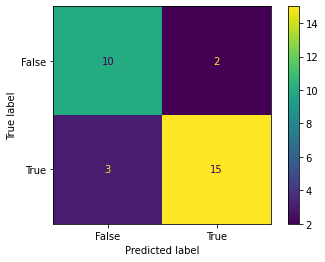

In [160]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predict_te, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

#### SVM with RBF kernels

In [161]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
clf_score_tr = []
clf_score_te = []
for i in np.arange(0.1, 2.5, 0.1):
    model = SVC(C=i,kernel="rbf")
    clf = model.fit(X_new, y_train)
    clf_score_tr.append(clf.score(X_new, y_train))
    clf_score_te.append(clf.score(X_t, y_test))

In [162]:
clf_score_tr

[0.6142857142857143,
 0.6142857142857143,
 0.7,
 0.9714285714285714,
 0.9857142857142858,
 0.9857142857142858,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [163]:
clf_score_te

[0.6,
 0.6,
 0.7333333333333333,
 0.8333333333333334,
 0.8666666666666667,
 0.7333333333333333,
 0.7333333333333333,
 0.7333333333333333,
 0.8,
 0.8,
 0.8333333333333334,
 0.8333333333333334,
 0.8333333333333334,
 0.8333333333333334,
 0.8333333333333334,
 0.8333333333333334,
 0.8333333333333334,
 0.8333333333333334,
 0.8333333333333334,
 0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667]

#### From the above, we can find that when C = 2.0, SVM with RBF kernels perform the best with the the lowest training error and the lowest testing error.

In [164]:
model = SVC(C=2.0,kernel="rbf")
clf = model.fit(X_new, y_train)
predict_te = clf.predict(X_t)
predict_tr = clf.predict(X_new)
# Calculate the confusion matrix and classification report for the train and test data. 
# Train data
print("-----------train data-----------")
print(confusion_matrix(y_train, predict_tr))
print(classification_report(y_train, predict_tr))
# Test data
print("-----------test data-----------")
print(confusion_matrix(y_test, predict_te))
print(classification_report(y_test, predict_te))

-----------train data-----------
[[27  0]
 [ 0 43]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        27
        True       1.00      1.00      1.00        43

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

-----------test data-----------
[[12  0]
 [ 4 14]]
              precision    recall  f1-score   support

       False       0.75      1.00      0.86        12
        True       1.00      0.78      0.88        18

    accuracy                           0.87        30
   macro avg       0.88      0.89      0.87        30
weighted avg       0.90      0.87      0.87        30



In [165]:
# Save the results in a data frame. 
report_tr = classification_report(y_train, predict_tr, output_dict=True)
report_tr = pd.DataFrame(report_tr).transpose()
report_te = classification_report(y_test, predict_te, output_dict=True)
report_te = pd.DataFrame(report_te).transpose()

In [166]:
# display the results data frame
print(report_tr)
print(report_te)

              precision  recall  f1-score  support
False               1.0     1.0       1.0     27.0
True                1.0     1.0       1.0     43.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     70.0
weighted avg        1.0     1.0       1.0     70.0
              precision    recall  f1-score    support
False          0.750000  1.000000  0.857143  12.000000
True           1.000000  0.777778  0.875000  18.000000
accuracy       0.866667  0.866667  0.866667   0.866667
macro avg      0.875000  0.888889  0.866071  30.000000
weighted avg   0.900000  0.866667  0.867857  30.000000


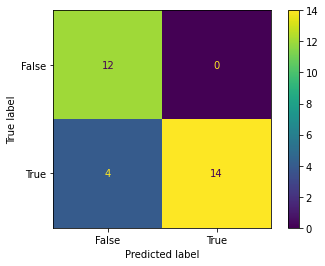

In [167]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predict_te, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

#### SVM with Sigmoid kernels

In [168]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
clf_score_tr = []
clf_score_te = []
for i in np.arange(0.1, 2.5, 0.1):
    model = SVC(C=i,kernel="sigmoid")
    clf = model.fit(X_new, y_train)
    clf_score_tr.append(clf.score(X_new, y_train))
    clf_score_te.append(clf.score(X_t, y_test))

In [169]:
clf_score_tr

[0.6142857142857143,
 0.6285714285714286,
 0.8142857142857143,
 0.9142857142857143,
 0.9714285714285714,
 0.9857142857142858,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [170]:
clf_score_te

[0.6,
 0.8,
 0.9,
 0.9333333333333333,
 0.9666666666666667,
 0.9666666666666667,
 0.9666666666666667,
 0.9666666666666667,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9]

#### From the above, we can find that when C = 0.7, SVM with Sigmoid kernels perform the best with the the lowest training error and the lowest testing error.

In [171]:
model = SVC(C=0.7,kernel="sigmoid")
clf = model.fit(X_new, y_train)
predict_te = clf.predict(X_t)
predict_tr = clf.predict(X_new)
# Calculate the confusion matrix and classification report for the train and test data. 
# Train data
print("-----------train data-----------")
print(confusion_matrix(y_train, predict_tr))
print(classification_report(y_train, predict_tr))
# Test data
print("-----------test data-----------")
print(confusion_matrix(y_test, predict_te))
print(classification_report(y_test, predict_te))

-----------train data-----------
[[27  0]
 [ 0 43]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        27
        True       1.00      1.00      1.00        43

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

-----------test data-----------
[[12  0]
 [ 1 17]]
              precision    recall  f1-score   support

       False       0.92      1.00      0.96        12
        True       1.00      0.94      0.97        18

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [172]:
# Save the results in a data frame. 
report_tr = classification_report(y_train, predict_tr, output_dict=True)
report_tr = pd.DataFrame(report_tr).transpose()
report_te = classification_report(y_test, predict_te, output_dict=True)
report_te = pd.DataFrame(report_te).transpose()

In [173]:
# display the results data frame
print(report_tr)
print(report_te)

              precision  recall  f1-score  support
False               1.0     1.0       1.0     27.0
True                1.0     1.0       1.0     43.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     70.0
weighted avg        1.0     1.0       1.0     70.0
              precision    recall  f1-score    support
False          0.923077  1.000000  0.960000  12.000000
True           1.000000  0.944444  0.971429  18.000000
accuracy       0.966667  0.966667  0.966667   0.966667
macro avg      0.961538  0.972222  0.965714  30.000000
weighted avg   0.969231  0.966667  0.966857  30.000000


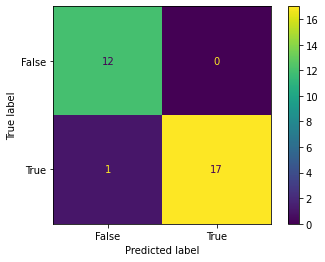

In [174]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predict_te, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

## Final results

#### From the above results, the best models for this problem are SVM with Linear kernels and C = 1.8, and SVM with Sigmoid kernels and C = 0.7.

#### SVM with Linear kernels and C = 1.8

In [175]:
model = SVC(C=1.8,kernel="linear")
clf = model.fit(X_new, y_train)
predict_te = clf.predict(X_t)
predict_tr = clf.predict(X_new)
# Calculate the confusion matrix and classification report for the train and test data. 
# Train data
print("-----------train data-----------")
print(confusion_matrix(y_train, predict_tr))
print(classification_report(y_train, predict_tr))
# Test data
print("-----------test data-----------")
print(confusion_matrix(y_test, predict_te))
print(classification_report(y_test, predict_te))

-----------train data-----------
[[27  0]
 [ 0 43]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        27
        True       1.00      1.00      1.00        43

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

-----------test data-----------
[[12  0]
 [ 1 17]]
              precision    recall  f1-score   support

       False       0.92      1.00      0.96        12
        True       1.00      0.94      0.97        18

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [176]:
# Save the results in a data frame. 
report_tr = classification_report(y_train, predict_tr, output_dict=True)
report_tr = pd.DataFrame(report_tr).transpose()
report_te = classification_report(y_test, predict_te, output_dict=True)
report_te = pd.DataFrame(report_te).transpose()

In [177]:
# display the results data frame
print(report_tr)
print(report_te)

              precision  recall  f1-score  support
False               1.0     1.0       1.0     27.0
True                1.0     1.0       1.0     43.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     70.0
weighted avg        1.0     1.0       1.0     70.0
              precision    recall  f1-score    support
False          0.923077  1.000000  0.960000  12.000000
True           1.000000  0.944444  0.971429  18.000000
accuracy       0.966667  0.966667  0.966667   0.966667
macro avg      0.961538  0.972222  0.965714  30.000000
weighted avg   0.969231  0.966667  0.966857  30.000000


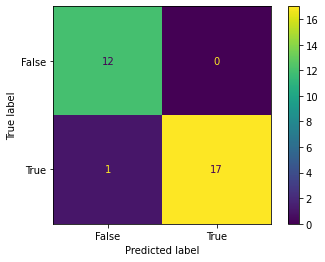

In [178]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predict_te, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

#### SVM with Sigmoid kernels and C = 0.7

In [179]:
model = SVC(C=0.7,kernel="sigmoid")
clf = model.fit(X_new, y_train)
predict_te = clf.predict(X_t)
predict_tr = clf.predict(X_new)
# Calculate the confusion matrix and classification report for the train and test data. 
# Train data
print("-----------train data-----------")
print(confusion_matrix(y_train, predict_tr))
print(classification_report(y_train, predict_tr))
# Test data
print("-----------test data-----------")
print(confusion_matrix(y_test, predict_te))
print(classification_report(y_test, predict_te))

-----------train data-----------
[[27  0]
 [ 0 43]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        27
        True       1.00      1.00      1.00        43

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

-----------test data-----------
[[12  0]
 [ 1 17]]
              precision    recall  f1-score   support

       False       0.92      1.00      0.96        12
        True       1.00      0.94      0.97        18

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [180]:
# Save the results in a data frame. 
report_tr = classification_report(y_train, predict_tr, output_dict=True)
report_tr = pd.DataFrame(report_tr).transpose()
report_te = classification_report(y_test, predict_te, output_dict=True)
report_te = pd.DataFrame(report_te).transpose()

In [181]:
# display the results data frame
print(report_tr)
print(report_te)

              precision  recall  f1-score  support
False               1.0     1.0       1.0     27.0
True                1.0     1.0       1.0     43.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     70.0
weighted avg        1.0     1.0       1.0     70.0
              precision    recall  f1-score    support
False          0.923077  1.000000  0.960000  12.000000
True           1.000000  0.944444  0.971429  18.000000
accuracy       0.966667  0.966667  0.966667   0.966667
macro avg      0.961538  0.972222  0.965714  30.000000
weighted avg   0.969231  0.966667  0.966857  30.000000


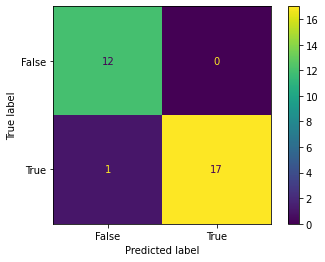

In [182]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predict_te, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

#### The performances in both two SVMs are very good with accurancy of 96.92% in the testing set and 100% in the training set. As we have done dimension reduction, SVM is suitable for this problem as there are many dimension and we can find a hyper-plane. We should use more data to detect which model is much better as the sample size increases.

## Conclusions:

### In general, the above results show us a phenomenon that we can judge whether such tweets can be forwarded and attract people's attention through the analysis of tweets. And the tweets forwarded have similarities in the use of words. From the above results, it can be seen that by using the same words and similar word frequency as tweets that have been forwarded many times, it can effectively help people to obtain forwarding without being ignored.

### As a popular social media, Twitter can not only enhance people's sense of social belonging, but also help them gain attention, reputation, fans and profit from it if they can get more forwarding volume and attention from it. For such an information age, it is beneficial for both the platform and bloggers to receive more attention.

### Such a study makes me more confident to observe the effect of the text itself on improving the quality of user accounts by comparing the growth of the text itself with the number of users' fans and the number of users' likes of tweets